In [1]:
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import casadi as ca
import pandas as pd


## Parameterize the track

In [2]:
# 1. set file path
file_path = "Nuerburgring.csv"

# 2. read csv file
df = pd.read_csv(file_path)

# 3. look head
print(df.head())

# 4. rename the first row
##df.rename(columns={'# x_m': 'x_m'}, inplace=True)

# 5. read the columns
x = df['# x_m'].values
y = df['y_m'].values
w_left = df['w_tr_left_m'].values
w_right = df['w_tr_right_m'].values

       # x_m        y_m  w_tr_right_m  w_tr_left_m
0   1.242679  -1.293111         7.288        7.487
1  -2.368512  -4.753954         7.307        7.469
2  -5.979276  -8.215237         7.342        7.426
3  -9.589590 -11.676983         7.377        7.383
4 -13.199433 -15.139219         7.411        7.340


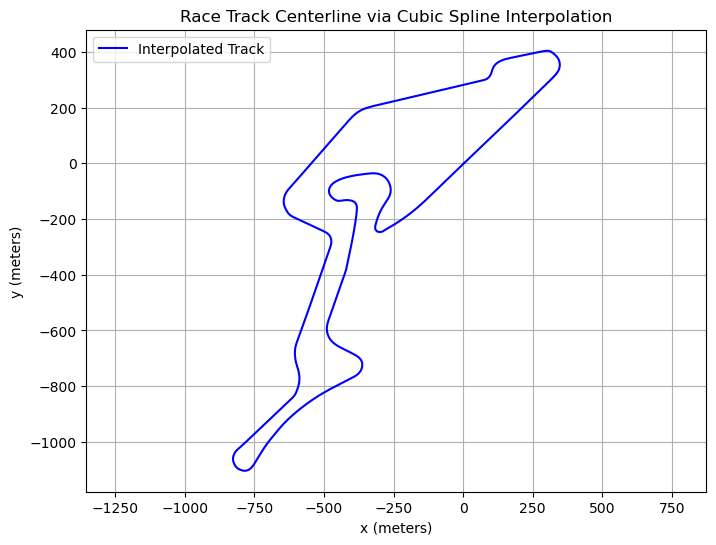

[4.96779e-05, 5.18275e-05, 5.39765e-05, 5.61084e-05, 5.82357e-05, 6.12083e-05, -1.43352e-05, -0.000163136, -0.000323732, -0.000484462, -0.00064534, -0.000806363, -0.000967503, -0.00112867, -0.00128948, -0.00143471, -0.00151807, -0.00149891, -0.00147973, -0.00146099, -0.00144278, -0.00142512, -0.00140795, -0.0013915, -0.00137559, -0.00139716, -0.00149303, -0.00172236, -0.00195052, -0.00215297, -0.00195556, -0.000778551, 0.00391004, 0.00192189, -0.0126263, -0.035024, -0.046885, -0.0602143, -0.0630226, -0.0503278, -0.0231227, -0.00450944, -0.00259848, -0.00351285, -0.00427517, -0.00499742, -0.00485795, -0.00451032, -0.00412058, -0.00378456, -0.00354099, -0.00163153, 0.000573206, 0.00430403, 0.01055, 0.0179625, 0.019042, 0.0182748, 0.0171586, 0.0162457, 0.0158292, 0.0158118, 0.0161807, 0.0169063, 0.0179554, 0.0185467, 0.0175816, 0.0159842, 0.0146875, 0.0118049, 0.00879252, 0.00559034, 0.00237834, -0.000465629, 0.000314345, 0.00101889, 0.00157269, 0.0020024, 0.00244309, 0.00289531, 0.003358

In [146]:
# Step 1: Compute arclengths
s = np.zeros(len(x))
s[1:] = np.cumsum(np.sqrt(np.diff(x)**2 + np.diff(y)**2))
s_max=s[-1] #the length of the track

# Step 2: Create cubic spline interpolators
x_spline = CubicSpline(s, x)
y_spline = CubicSpline(s, y)

# Step 3: Get the first and second derivative of the parameteriation
dx_ds = x_spline.derivative(1)
d2x_ds2 = x_spline.derivative(2)
dy_ds = y_spline.derivative(1)
d2y_ds2 = y_spline.derivative(2)

## Generate interpolated values for plotting
s_query = np.linspace(0, s_max, 500)
x_interp = x_spline(s_query)
y_interp = y_spline(s_query)

## Plot the spline
plt.figure(figsize=(8, 6))
plt.plot(x_interp, y_interp, label='Interpolated Track', color='blue')
##plt.plot(x, y, 'ro', label='Original Points')
plt.axis('equal')
plt.title('Race Track Centerline via Cubic Spline Interpolation')
plt.xlabel('x (meters)')
plt.ylabel('y (meters)')
plt.legend()
plt.grid(True)
plt.show()

# output parameterisation and curvature as a casadi instance
x_ref = ca.interpolant('x_ref', 'linear', [s_query], x_interp)
y_ref = ca.interpolant('y_ref', 'linear', [s_query], y_interp)
kappa_ref_ = dx_ds(s_query)*d2y_ds2(s_query)-dy_ds(s_query)*d2x_ds2(s_query)
kappa_ref = ca.interpolant('kappa', 'linear', [s_query], kappa_ref_)


## Find optimal reference path

Using $(s, r)$ to represent the vehicle's position, where $s$ is the projection on the centre line and $r$ is the lateral distance relative to it. Let $\kappa(t)$ be the curvature of the path at time $t$, $T$ be the predictive time scale, $t_i$ be the initial time, $\psi(t)$ be the path angle at time $t$, and $\psi_{\text{ref}}(t)$ be the centre line's angle at the vehicle's position at time $t$.

---

**Side notes – coordinate transform:**

$$
\kappa_{\text{ref}}(s) = \frac{x'_{\text{ref}}(s) y''_{\text{ref}}(s) - y'_{\text{ref}}(s) x''_{\text{ref}}(s)}{(x'_{\text{ref}}(s)^2 + y'_{\text{ref}}(s)^2)^{3/2}}
$$

$$
x(t) = x_{\text{ref}}(S(t)) - r(t) \cdot \sin(\psi_{\text{ref}}(S(t)))
$$

$$
y(t) = y_{\text{ref}}(S(t)) + r(t) \cdot \cos(\psi_{\text{ref}}(S(t)))
$$

---

According to Mathias, one possible formulation of this problem is the following:

### Objective

Minimize the objective function:

$$
-s(t_i + T)
$$

### Subject to:

- **System dynamics:**
$$
\dot{x} = f(x,u)
$$
where
$$
x(t) =
\begin{bmatrix}
s(t) \\
n(t) \\
\xi(t) \\
\beta(t) \\
\dot{\Psi}(t) \\
v(t)
\end{bmatrix} \textit{is the state variable},
$$

$$
u(t) = 
\begin{bmatrix}
\delta_f(t)\\
F_{dr}(t)
\end{bmatrix} \textit{is the control variable},
$$

$$
f(x,u) =
\begin{bmatrix}
\frac{v \cdot \cos(\xi + \beta)}{1 - n \kappa(s(t))} \\
v \cdot \sin(\xi + \beta) \\[1.2ex]
\dot{\Psi} - \kappa \cdot \frac{v \cos(\xi + \beta)}{1 - n \kappa(s(t))} \\[1.2ex]
\left( -\dot{\Psi} + \frac{1}{m \cdot v} \left[ 
(F_{Yfl} + F_{Yfr}) \cos(\delta_f - \beta) +
(F_{Yrl} + F_{Yrr}) \cos(\delta_r - \beta) - F_{dr} \sin(\beta)
\right] \right) \\[2ex]
\frac{1}{J_{zz}} \left[
F_{Yfl} \left( l_f \cos \delta_f - \frac{w_f}{2} \sin \delta_f \right) +
F_{Yfr} \left( l_f \cos \delta_f + \frac{w_f}{2} \sin \delta_f \right) + 
F_{Yrl} \left( -l_r \cos \delta_r - \frac{w_r}{2} \sin \delta_r \right) +
F_{Yrr} \left( -l_r \cos \delta_r + \frac{w_r}{2} \sin \delta_r \right)
\right] \\[2ex]
\frac{1}{m} \left[
(F_{Yfl} + F_{Yfr}) \sin(\beta - \delta_f) +
(F_{Yrl} + F_{Yrr}) \sin(\beta - \delta_r) +
F_{dr} \cos \beta - F_{roll} - [F_{aero}]\textit{(omit this term for now)}
\right]
\end{bmatrix},
$$


$$
F_{\text{roll}} = \mu_{roll} \cdot m \cdot g
\\
[F_{\text{aero}} = \frac{1}{2} \cdot \rho \cdot C_d \cdot A_f \cdot v^2] \textit{(omit this term for now)}
\\
F_Z = F_{Zfl} = F_{Zfr} = F_{Zrl} = F_{Zrr} = \frac{1}{4} m \cdot g
\\
\alpha_{fl} = \delta_f - \arctan\left( \frac{v \cdot \sin \beta + l_f \cdot \dot{\Psi}}{v \cdot \cos \beta - \frac{w_f}{2} \cdot \dot{\Psi}} \right)
\\
\alpha_{fr} = \delta_f - \arctan\left( \frac{v \cdot \sin \beta + l_f \cdot \dot{\Psi}}{v \cdot \cos \beta + \frac{w_f}{2} \cdot \dot{\Psi}} \right)
\\
\alpha_{rl} = \delta_r - \arctan\left( \frac{v \cdot \sin \beta - l_r \cdot \dot{\Psi}}{v \cdot \cos \beta -\frac{w_r}{2} \cdot \dot{\Psi}} \right)
\\
\alpha_{rr} = \delta_r - \arctan\left( \frac{v \cdot \sin \beta - l_r \cdot \dot{\Psi}}{v \cdot \cos \beta + \frac{w_r}{2} \cdot \dot{\Psi}} \right)
$$

$$
F_{Yfl} = \sin\left(1.9 \cdot \arctan(10 \cdot \sin(\alpha_{fl}))\right) + 0.97 \cdot \sin\left(\arctan(10 \cdot \sin(\alpha_{fl}))\right)
\\
F_{Yfr} = \sin\left(1.9 \cdot \arctan(10 \cdot \sin(\alpha_{fr}))\right) + 0.97 \cdot \sin\left(\arctan(10 \cdot \sin(\alpha_{fr}))\right)
\\
F_{Yrl} = \sin\left(1.9 \cdot \arctan(10 \cdot \sin(\alpha_{rl}))\right) + 0.97 \cdot \sin\left(\arctan(10 \cdot \sin(\alpha_{rl}))\right)
\\
F_{Yrr} = \sin\left(1.9 \cdot \arctan(10 \cdot \sin(\alpha_{rr}))\right) + 0.97 \cdot \sin\left(\arctan(10 \cdot \sin(\alpha_{rr}))\right)
$$



- **Initial conditions:**

$$
x(0)=x_0
$$

- **State constraints:**

$$
n(t) \in [n_{\min}(s(t)),\, n_{\max}(s(t))]
$$

- **Control constraints:**

$$
F_{dr}\leq F_{MAX}
\\
|\delta_f| \leq \delta_{MAX}
\\
\left( \frac{F_{Yfl}}{\mu F_Z} \right)^2 + \left( \frac{0.25 \cdot F_{\text{roll}}}{\mu F_Z} \right)^2 \leq 1
\\
\left( \frac{F_{Yfr}}{\mu F_Z} \right)^2 + \left( \frac{0.25 \cdot F_{\text{roll}}}{\mu F_Z} \right)^2 \leq 1
\\
\left( \frac{F_{Yrl}}{\mu F_Z} \right)^2 + \left( \frac{0.25 \cdot \left( F_{dr}+F_{\text{roll}}\right)}{\mu F_Z} \right)^2 \leq 1
\\
\left( \frac{F_{Yrr}}{\mu F_Z} \right)^2 + \left( \frac{0.25 \cdot \left( F_{dr}+F_{\text{roll}}\right)}{\mu F_Z} \right)^2 \leq 1
$$


In [149]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

# Constants
N = 40                # Discretization steps
T = 20                # Time horizon
dt = T / N
m = 1500               # Mass (kg)
g = 9.81               # Gravity (m/s^2)
mu_roll = 0.008        # Rolling friction coefficient of the tire
mu=1                   # Peak friction coefficient
F_MAX = 3000           # Max driving force (N)
F_MIN = -3000
delta_MAX = np.pi / 6 # Max steering angle (rad)
J_zz = 3000            # Yaw inertia (kg*m^2)

# Geometry
l_f = 1.5
l_r = 1.5
w_f = 1.2
w_r = 1.2

# Create optimization problem
opti = ca.Opti()

# State variables
s = opti.variable(N+1)
n = opti.variable(N+1)
xi = opti.variable(N+1)
beta = opti.variable(N+1)
psi_dot = opti.variable(N+1)
v = opti.variable(N+1)

# Control variables
delta_f = opti.variable(N)
F_dr = opti.variable(N)

# Road profile functions
def kappa_s(s_val):
    return kappa_ref(s_val)

def n_bounds_s(s_val):
    return -10, 10

def F_y(alpha):
    return ca.sin(1.9 * ca.atan(10 * ca.sin(alpha))) + 0.97 * ca.sin(ca.atan(10 * ca.sin(alpha)))

F_roll = mu_roll * m * g
F_Z = m * g / 4

# Dynamics
for k in range(N):
    kappa = kappa_s(s[k])
    alpha_fl = delta_f[k] - ca.atan2(v[k]*ca.sin(beta[k]) + l_f*psi_dot[k], v[k]*ca.cos(beta[k]) - w_f/2*psi_dot[k])
    alpha_fr = delta_f[k] - ca.atan2(v[k]*ca.sin(beta[k]) + l_f*psi_dot[k], v[k]*ca.cos(beta[k]) + w_f/2*psi_dot[k])
    alpha_rl = - ca.atan2(v[k]*ca.sin(beta[k]) - l_r*psi_dot[k], v[k]*ca.cos(beta[k]) - w_r/2*psi_dot[k])
    alpha_rr = - ca.atan2(v[k]*ca.sin(beta[k]) - l_r*psi_dot[k], v[k]*ca.cos(beta[k]) + w_r/2*psi_dot[k])

    FYfl = F_y(alpha_fl)
    FYfr = F_y(alpha_fr)
    FYrl = F_y(alpha_rl)
    FYrr = F_y(alpha_rr)

    ds = v[k]*ca.cos(xi[k] + beta[k]) / (1 - n[k]*kappa)
    dn = v[k]*ca.sin(xi[k] + beta[k])
    dxi = psi_dot[k] - kappa * ds
    dbeta = (-psi_dot[k] + 1/(m*v[k]) * (
        (FYfl + FYfr)*ca.cos(delta_f[k] - beta[k]) +
        (FYrl + FYrr)*ca.cos(- beta[k]) - F_dr[k]*ca.sin(beta[k])
    ))
    dpsi_dot = 1/J_zz * (
        FYfl*(l_f*ca.cos(delta_f[k]) - w_f/2*ca.sin(delta_f[k])) +
        FYfr*(l_f*ca.cos(delta_f[k]) + w_f/2*ca.sin(delta_f[k])) +
        FYrl*(-l_r) +
        FYrr*(-l_r)
    )
    dv = 1/m * (
        (FYfl + FYfr)*ca.sin(beta[k] - delta_f[k]) +
        (FYrl + FYrr)*ca.sin(beta[k]) +
        F_dr[k]*ca.cos(beta[k]) - F_roll
    )

    # Euler integration
    opti.subject_to(s[k+1] == s[k] + dt*ds)
    opti.subject_to(n[k+1] == n[k] + dt*dn)
    opti.subject_to(xi[k+1] == xi[k] + dt*dxi)
    opti.subject_to(beta[k+1] == beta[k] + dt*dbeta)
    opti.subject_to(psi_dot[k+1] == psi_dot[k] + dt*dpsi_dot)
    opti.subject_to(v[k+1] == v[k] + dt*dv)

    # Control constraints
    opti.subject_to(F_dr[k] <= F_MAX)
    opti.subject_to(F_dr[k] >= F_MIN)
    opti.subject_to(ca.fabs(delta_f[k]) <= delta_MAX)

    # Friction ellipse constraints
    opti.subject_to((FYfl/(mu*F_Z))**2 + (0.25*F_roll/(mu*F_Z))**2 <= 1)
    opti.subject_to((FYfr/(mu*F_Z))**2 + (0.25*F_roll/(mu*F_Z))**2 <= 1)
    opti.subject_to((FYrl/(mu*F_Z))**2 + ((F_dr[k]+0.25*F_roll)/(mu*F_Z))**2 <= 1)
    opti.subject_to((FYrr/(mu*F_Z))**2 + ((F_dr[k]+0.25*F_roll)/(mu*F_Z))**2 <= 1)

# Initial conditions
opti.subject_to(s[0] == 0)
opti.subject_to(n[0] == 0)
opti.subject_to(xi[0] == 0)
opti.subject_to(beta[0] == 0)
opti.subject_to(psi_dot[0] == 0)
opti.subject_to(v[0] == 0.5)

# Road bounds
for k in range(N+1):
    nmin, nmax = n_bounds_s(s[k])
    opti.subject_to(n[k] >= nmin)
    opti.subject_to(n[k] <= nmax)
# 速度边界
for k in range(N+1):
    opti.subject_to(v[k] >= 0.5)  # 防止除零


# Objective: maximize s at final time
opti.minimize(-s[N])

# Solver options
opti.set_initial(s, np.linspace(0, 50, N+1)) #np.linspace(0, 50, N+1)
opti.set_initial(n, 0)
opti.set_initial(xi, 0)
opti.set_initial(beta, 0)
opti.set_initial(psi_dot, 0)
opti.set_initial(v, 10)
opti.set_initial(delta_f, 0)
opti.set_initial(F_dr, 0)

# Solver
p_opts = {"expand": True}
s_opts = {
    "print_level": 5,
    "tol": 1e-4,            # 原来是 1e-4，放宽
    "max_iter": 5000,       # 增大迭代次数
    "acceptable_tol": 1e-2, # 设置“可接受解”的容差
    "acceptable_iter": 10   # 若连续满足acceptable_tol，可以提前接受
}
opti.solver('ipopt', p_opts, s_opts)

try:
    sol = opti.solve()
except RuntimeError:
    print("Solver failed.")
    print("Last value of v:", opti.debug.value(v))
    print("Last value of n:", opti.debug.value(n))
    print("Last value of F_dr:", opti.debug.value(F_dr))
    raise
    

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1406
Number of nonzeros in inequality constraint Jacobian.:      883
Number of nonzeros in Lagrangian Hessian.............:     1000

Total number of variables............................:      326
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:      403
        inequality constraints with only lower bounds:      122
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      281

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -5.0000000e+01 9.50e+00 6.59e-03  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

  94 -3.8472980e+02 1.88e-03 2.34e-02  -3.8 8.69e+02    -  1.00e+00 1.00e+00h  1
  95 -3.8472980e+02 1.56e-03 2.34e-02  -3.8 3.11e+03    -  8.57e-04 3.05e-05h 16
  96 -3.8472980e+02 1.30e-03 2.34e-02  -3.8 3.94e+03    -  1.00e+00 1.53e-05h 17
  97 -3.8472978e+02 1.29e-03 2.33e-02  -3.8 1.60e+02    -  1.00e+00 3.91e-03h  9
  98 -3.8472978e+02 1.29e-03 2.33e-02  -3.8 9.44e+03    -  1.33e-04 9.54e-07h 21
  99 -3.8472483e+02 1.18e-04 2.53e-02  -3.8 9.49e-02  -0.6 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 -3.8472477e+02 1.20e-04 2.37e-02  -3.8 2.67e+00    -  9.92e-01 6.25e-02h  5
 101 -3.8472365e+02 1.43e-04 7.33e-03  -3.8 8.25e-02  -1.1 1.00e+00 1.00e+00h  1
 102 -3.8472367e+02 2.43e-04 6.87e-03  -3.8 1.52e+02    -  1.00e+00 6.25e-02h  5
 103 -3.8472367e+02 2.56e-04 6.87e-03  -3.8 1.43e+02    -  1.00e+00 2.44e-04h 13
 104 -3.8472367e+02 2.66e-04 6.76e-03  -3.8 1.43e+02    -  1.00e+00 1.56e-02h  7
 105 -3.8472367e+02 2.67e-04

 196 -3.8472372e+02 5.18e+03 3.85e-05  -3.8 1.16e+04  -8.4 1.00e+00 1.00e+00h  1
 197 -3.8472372e+02 1.30e+03 2.86e-05  -3.8 3.84e+05  -8.9 1.39e-02 1.01e-02h  6
 198 -3.8472372e+02 2.39e+03 6.97e-06  -3.8 7.38e+03  -8.5 1.00e+00 5.00e-01h  2
 199 -3.8472372e+02 3.61e+03 3.44e-05  -3.8 5.99e+03  -8.1 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200 -3.8472372e+02 3.51e+03 2.06e-05  -3.8 7.11e+03  -8.5 1.00e+00 1.00e+00h  1
 201 -3.8472372e+02 7.07e+02 2.20e-05  -3.8 4.21e+03  -8.1 1.00e+00 1.00e+00h  1
 202 -3.8472372e+02 6.48e+02 3.19e-06  -3.8 1.36e+03  -8.6 1.00e+00 1.00e+00h  1
 203 -3.8472372e+02 1.60e+02 3.79e-06  -3.8 8.08e+02  -8.2 1.00e+00 1.00e+00h  1
 204 -3.8472372e+02 1.52e+02 2.69e-06  -3.8 3.06e+02    -  1.00e+00 5.25e-01h  1
 205 -3.8472372e+02 8.79e+01 6.40e-07  -3.8 2.41e+02    -  7.27e-01 1.00e+00h  1
 206 -3.8472372e+02 2.08e+03 7.97e-06  -3.8 2.17e+03  -8.6 1.00e+00 1.00e+00h  1
 207 -3.8472372e+02 6.74e+02

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290 -3.8472372e+02 1.34e+03 9.58e-06  -3.8 1.63e+03  -8.1 1.00e+00 1.00e+00h  1
 291 -3.8472372e+02 1.52e+02 4.42e-06  -3.8 2.99e+03  -8.6 1.00e+00 5.00e-01h  2
 292 -3.8472372e+02 3.42e+02 4.64e-06  -3.8 9.91e+02  -8.1 1.00e+00 5.00e-01h  2
 293 -3.8472372e+02 3.41e+02 1.29e-06  -3.8 1.51e+03    -  1.00e+00 7.74e-01h  1
 294 -3.8472372e+02 4.85e+02 2.49e-06  -3.8 8.26e+02    -  1.11e-01 1.00e+00h  1
 295 -3.8472372e+02 2.44e+02 1.99e-06  -3.8 1.46e+03  -8.6 1.00e+00 5.00e-01h  2
 296 -3.8472372e+02 3.89e+02 2.53e-06  -3.8 6.34e+02  -8.2 1.00e+00 1.00e+00h  1
 297 -3.8472372e+02 8.97e+01 1.18e-06  -3.8 9.60e+02  -8.7 1.00e+00 5.00e-01h  2
 298 -3.8472372e+02 1.15e+02 1.23e-06  -3.8 4.12e+02  -8.2 1.00e+00 5.00e-01h  2
 299 -3.8472372e+02 3.39e+02 1.06e-06  -3.8 9.10e+02  -8.7 9.89e-01 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300 -3.8472372e+02 3.38e+02

 475 -3.4602447e+02 7.12e-10 3.74e-02  -3.8 5.12e-04   1.9 1.00e+00 1.00e+00f  1
 476 -3.4602465e+02 6.63e-09 2.79e-02  -3.8 1.15e-03   1.4 1.00e+00 1.00e+00f  1
 477 -3.4602517e+02 6.43e-08 1.42e-02  -3.8 1.75e-03   0.9 1.00e+00 1.00e+00f  1
 478 -3.4602665e+02 6.67e-07 9.69e-03  -3.8 3.58e-03   0.4 1.00e+00 1.00e+00f  1
 479 -3.4603037e+02 6.72e-06 1.51e-02  -3.8 9.53e-03  -0.0 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 480 -3.4603649e+02 1.53e-05 4.96e-02  -3.8 2.14e-02  -0.5 1.00e+00 1.00e+00h  1
 481 -3.4604757e+02 6.88e-05 8.93e-03  -3.8 8.04e-02  -1.0 1.00e+00 1.00e+00h  1
 482 -3.4606265e+02 1.74e-03 9.85e-02  -3.8 3.20e-01  -1.5 1.00e+00 1.00e+00h  1
 483 -3.4607748e+02 1.36e-03 4.90e-01  -3.8 4.59e-01  -0.1 1.00e+00 1.00e+00h  1
 484 -3.4606538e+02 4.51e-04 6.95e+00  -3.8 3.57e-01   1.2 1.00e+00 1.00e+00h  1
 485 -3.4606075e+02 2.47e-04 7.38e-01  -3.8 9.65e-02   0.7 1.00e+00 1.00e+00h  1
 486 -3.4605463e+02 2.09e-05

 579 -3.8472577e+02 2.68e+03 4.01e+00  -3.8 1.56e+03  -1.6 1.00e+00 5.52e-02h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 580 -3.8472576e+02 2.68e+03 4.02e+00  -3.8 1.56e+03  -2.1 1.00e+00 6.44e-04h  9
 581 -3.8472511e+02 2.42e+03 3.97e+00  -3.8 1.47e+03  -2.6 1.00e+00 1.75e-01h  1
 582 -3.8472511e+02 2.42e+03 3.97e+00  -3.8 1.95e+03  -3.1 1.00e+00 8.14e-05h  1
 583 -3.8472302e+02 5.16e+00 6.69e-01  -3.8 2.42e+03  -3.5 5.75e-01 1.00e+00h  1
 584 -3.8472109e+02 4.19e-01 3.85e-03  -3.8 6.63e+00  -3.1 1.00e+00 1.00e+00h  1
 585 -3.8472439e+02 2.72e+00 2.71e-03  -3.8 4.18e+00  -3.6 1.00e+00 1.00e+00h  1
 586 -3.8472402e+02 2.69e+00 1.14e-03  -3.8 6.44e+00    -  1.00e+00 5.85e-01h  1
 587 -3.8472454e+02 9.26e+02 4.53e-02  -3.8 1.85e+03    -  3.59e-02 5.00e-01h  2
 588 -3.8472322e+02 1.08e+00 7.75e-02  -3.8 9.27e+02  -4.1 8.95e-01 1.00e+00h  1
 589 -3.8472379e+02 2.47e+00 1.09e-04  -3.8 3.37e+00  -4.6 1.00e+00 1.00e+00h  1
iter    objective    inf_pr 

 677 -3.8472372e+02 6.95e+01 8.33e-06  -3.8 5.78e+03  -8.5 1.00e+00 3.12e-02h  6
 678 -3.8472372e+02 2.15e+01 8.28e-06  -3.8 9.84e+04  -9.0 8.16e-02 4.88e-04h 12
 679 -3.8472372e+02 8.43e+03 2.21e-04  -3.8 8.45e+03  -7.6 1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 680 -3.8472372e+02 8.42e+03 1.10e-04  -3.8 1.69e+04    -  1.00e+00 5.00e-01w  1
 681 -3.8472372e+02 4.97e+03 1.08e-04  -3.8 1.34e+04    -  5.39e-04 1.00e+00w  1
 682 -3.8472372e+02 1.05e+01 8.17e-06  -3.8 6.71e+03  -8.1 1.00e+00 3.91e-03h  8
 683 -3.8472372e+02 4.28e+00 8.15e-06  -3.8 8.09e+03  -8.6 1.00e+00 1.95e-03h 10
 684 -3.8472372e+02 1.33e+01 8.20e-06  -3.8 4.76e+03  -8.2 1.00e+00 3.91e-03h  9
 685 -3.8472372e+02 3.57e+00 8.17e-06  -3.8 9.15e+03  -8.6 1.00e+00 1.95e-03h 10
 686 -3.8472372e+02 1.33e+01 8.21e-06  -3.8 4.59e+03  -8.2 1.00e+00 3.91e-03h  9
 687 -3.8472372e+02 2.23e+00 8.20e-06  -3.8 1.14e+04  -8.7 1.00e+00 9.77e-04h 11
 688 -3.8472372e+02 2.05e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 860 -3.4152305e+02 6.44e+01 3.04e-05  -3.8 3.49e+03  -8.4 9.25e-02 3.12e-02h  6
 861 -3.4152305e+02 5.57e+00 3.74e-05  -3.8 2.84e+02  -8.0 1.00e+00 2.50e-01h  3
 862 -3.4152305e+02 5.23e-02 2.13e-05  -3.8 3.92e+02  -7.6 1.00e+00 1.56e-02h  7
 863 -3.4152306e+02 1.59e+01 1.61e-05  -3.8 3.26e+02    -  1.00e+00 1.00e+00h  1
 864 -3.4152306e+02 9.85e+01 8.05e-06  -3.8 2.31e+02    -  5.88e-01 5.00e-01h  2
 865 -3.4152306e+02 1.17e+02 1.27e-06  -3.8 2.17e+02  -8.0 1.00e+00 1.00e+00h  1
 866 -3.4152306e+02 6.35e+00 5.54e-07  -3.8 4.99e+02    -  4.46e-01 2.50e-01h  3
 867 -3.4152306e+02 3.69e+01 5.17e-07  -3.8 3.55e+02  -8.5 1.00e+00 1.25e-01h  4
 868 -3.4152306e+02 5.95e+00 3.08e-07  -3.8 9.91e+02  -8.1 2.66e-01 3.12e-02h  6
 869 -3.4152306e+02 4.56e+01 5.70e-07  -3.8 3.36e+03  -8.6 1.00e+00 1.56e-02h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 870 -3.4152306e+02 1.16e+02

 953 -3.4152306e+02 1.52e+02 2.96e-06  -3.8 6.31e+02  -8.1 1.00e+00 1.00e+00h  1
 954 -3.4152306e+02 6.58e+03 2.09e-05  -3.8 1.35e+04    -  1.17e-02 5.00e-01h  2
 955 -3.4152306e+02 5.22e+03 2.56e-05  -3.8 1.18e+04  -8.6 1.00e+00 1.00e+00h  1
 956 -3.4152306e+02 2.16e+03 1.63e-05  -3.8 6.10e+03  -8.2 1.00e+00 5.00e-01h  2
 957 -3.4152306e+02 2.26e+03 8.06e-06  -3.8 4.43e+03  -8.7 1.00e+00 1.00e+00h  1
 958 -3.4152306e+02 7.63e+02 5.47e-06  -3.8 3.00e+03  -8.2 1.00e+00 5.00e-01h  2
 959 -3.4152306e+02 1.20e+03 5.35e-05  -3.8 7.87e+03  -7.8 2.62e-01 2.50e-01h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 960 -3.4152306e+02 3.43e+02 2.13e-05  -3.8 3.10e+03  -8.3 1.00e+00 5.00e-01h  2
 961 -3.4152306e+02 1.37e+05 4.35e-04  -3.8 1.33e+04  -8.8 2.21e-02 1.00e+00H  1
 962 -3.4152306e+02 1.37e+05 3.38e-04  -3.8 2.49e+05    -  1.00e+00 2.24e-01h  2
 963 -3.4152306e+02 9.68e+04 6.48e-04  -3.8 1.36e+05  -7.4 1.00e+00 2.97e-01h  1
 964 -3.4152283e+02 3.34e+04

1048 -3.0722936e+02 1.15e-02 7.10e-02  -5.0 7.13e+03  -6.6 5.43e-01 1.63e-02f  1
1049 -3.1164758e+02 1.26e-02 7.29e-02  -5.0 1.53e+04  -7.1 1.25e-01 5.64e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1050 -3.2797734e+02 2.71e-02 7.07e-02  -5.0 3.33e+04  -7.5 2.01e-01 1.00e-02f  1
1051 -3.5475943e+02 8.08e-02 9.83e-02  -5.0 4.54e+04  -8.0 7.43e-02 1.37e-02f  1
1052 -3.7288135e+02 1.25e-01 1.50e-01  -5.0 8.15e+04  -8.5 3.01e-02 9.99e-03f  1
1053 -3.7300728e+02 1.25e-01 1.50e-01  -5.0 3.84e+03  -6.3 7.58e-01 1.10e-03f  1
1054 -3.7536649e+02 1.24e-01 1.46e-01  -5.0 1.35e+04  -6.7 3.84e-01 1.10e-02f  1
1055 -3.7738769e+02 1.21e-01 1.38e-01  -5.0 8.88e+03  -7.2 9.19e-01 2.45e-02f  1
1056 -3.7925211e+02 1.18e-01 1.30e-01  -5.0 1.99e+04  -7.7 1.00e+00 1.95e-02f  1
1057 -3.8111945e+02 1.09e+00 1.29e-01  -5.0 3.33e+04  -8.2 2.28e-02 2.23e-02f  1
1058 -3.8175566e+02 2.63e-01 1.28e-01  -5.0 7.40e+04  -8.6 2.22e-01 5.99e-03f  1
1059 -3.8251386e+02 1.15e-01

1236r-3.4464144e+02 6.81e-04 1.52e-02  -2.6 6.32e+00    -  1.00e+00 1.00e+00H  1
1237r-3.4418574e+02 1.23e-03 2.42e-02  -2.6 5.43e+00    -  1.00e+00 1.00e+00H  1
1238r-3.4413016e+02 1.55e-03 8.15e-03  -2.6 4.75e+00    -  1.00e+00 1.00e+00h  1
1239r-3.4477555e+02 9.14e-04 5.97e-01  -2.6 1.26e+01    -  1.00e+00 5.00e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1240r-3.4447120e+02 7.43e-04 1.56e-01  -2.6 1.43e+01    -  8.51e-01 2.50e-01h  3
1241r-3.4460151e+02 5.59e-04 1.44e-02  -2.6 3.20e+00    -  1.00e+00 1.00e+00H  1
1242r-3.4440326e+02 1.08e-03 6.47e-01  -2.6 7.87e+00    -  1.00e+00 5.00e-01h  2
1243r-3.4470423e+02 5.44e-04 1.81e-02  -2.6 4.63e+00    -  1.00e+00 1.00e+00H  1
1244r-3.4440367e+02 5.01e-04 1.03e+00  -2.6 1.16e+01    -  1.00e+00 2.50e-01h  3
1245r-3.4438524e+02 7.79e-04 2.77e-01  -2.6 3.42e+00    -  1.00e+00 5.00e-01h  2
1246r-3.4483439e+02 1.26e-03 3.51e-01  -2.6 9.13e+00    -  1.00e+00 5.00e-01h  2
1247r-3.4458558e+02 1.16e-03

1329r-3.4771430e+02 7.36e-03 8.74e+02  -3.4 4.72e-01   0.6 1.35e-01 1.44e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1330r-3.4766640e+02 8.58e-03 1.04e+03  -3.4 2.63e-01   1.1 8.62e-02 4.13e-01f  1
1331r-3.4766521e+02 8.28e-03 9.90e+02  -3.4 1.18e-01   1.5 3.57e-02 4.98e-02f  1
1332r-3.4766502e+02 8.13e-03 2.82e+03  -3.4 9.23e-02   1.9 1.12e-01 5.89e-03h  1
1333r-3.4765338e+02 8.29e-03 7.28e+02  -3.4 6.37e-01   1.4 4.61e-03 1.35e-01f  1
1334r-3.4764374e+02 1.05e-02 6.71e+02  -3.4 2.51e-01   1.0 2.22e-01 6.39e-02f  1
1335r-3.4764160e+02 1.00e-02 5.95e+02  -3.4 9.56e-02   1.4 7.32e-02 1.04e-01f  1
1336r-3.4764094e+02 1.03e-02 5.49e+02  -3.4 8.04e-02   1.8 2.42e-01 7.61e-02h  1
1337r-3.4763973e+02 1.01e-02 5.34e+02  -3.4 1.29e-01   1.3 7.59e-01 2.70e-02f  1
1338r-3.4764140e+02 9.32e-03 3.04e+02  -3.4 8.87e-02   1.8 3.11e-01 4.31e-01h  1
1339r-3.4764177e+02 9.61e-03 8.71e+01  -3.4 5.77e-02   2.2 1.00e+00 7.13e-01f  1
iter    objective    inf_pr 

RuntimeError: Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:217:
.../casadi/core/optistack_internal.cpp:1336: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use opti.debug.value to investigate the latest values of variables. return_status is 'Infeasible_Problem_Detected'

In [ ]:
#opti.debug.show_infeasibilities()

In [ ]:
# Extract results
s_opt = sol.value(s)
n_opt = sol.value(n)
v_opt = sol.value(v)
F_dr_opt=sol.value(F_dr)
delta_opt = sol.value(delta_f)

# Plot results
plt.figure(figsize=(10,5))
plt.plot(s_opt, v_opt, label='Trajectory (v vs s)')
plt.plot(s_opt, n_opt, label='Trajectory (n vs s)')
plt.plot(s_opt[0:40], delta_opt, label='Trajectory (delta_f vs s)')


plt.xlabel("s")
plt.title("Optimized variables w.r.t. arclength")
plt.grid(True)
plt.legend()
plt.show()

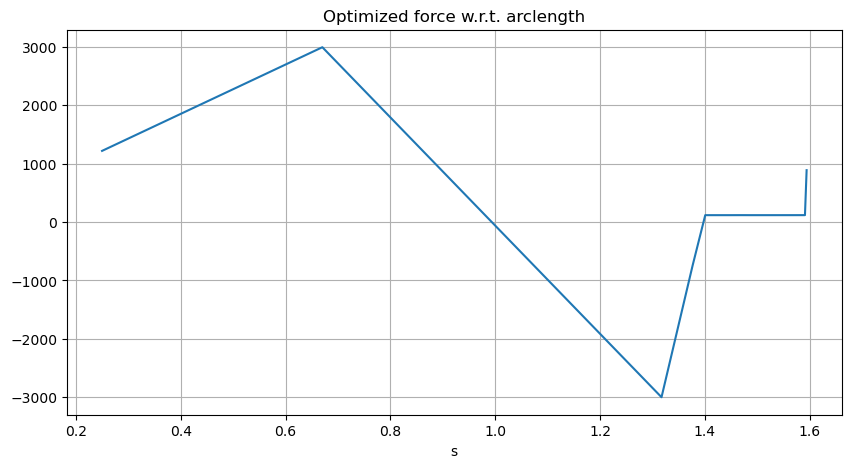

In [129]:
plt.figure(figsize=(10,5))
plt.plot(s_opt[1:41], F_dr_opt[0:40])

plt.xlabel("s")
plt.title("Optimized force w.r.t. arclength")
plt.grid(True)
plt.show()

In [130]:
# coordinate transform
phi_ref_val=ca.atan(dy_ds(s_opt)/dx_ds(s_opt))
x_val=x_ref(s_opt).full().flatten()-n_opt*np.sin(phi_ref_val)
y_val=y_ref(s_opt).full().flatten()+n_opt*np.cos(phi_ref_val)

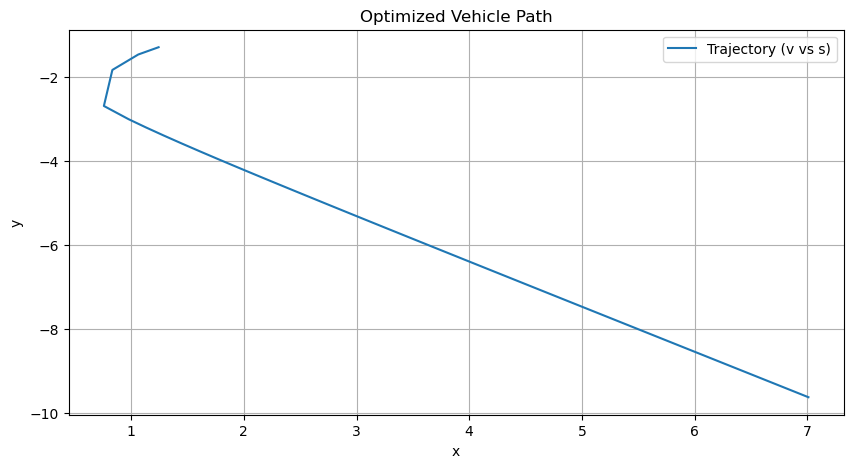

In [131]:
# plot in the new coordinate
plt.figure(figsize=(10,5))
plt.plot(x_val, y_val, label='Trajectory (v vs s)')

plt.xlabel("x")
plt.ylabel("y")

plt.title("Optimized Vehicle Path")
plt.grid(True)
plt.legend()
plt.show()

In [141]:
print(kappa_ref(np.linspace(1,10)))

[2.34816e-05, 2.35288e-05, 2.3576e-05, 2.36232e-05, 2.36704e-05, 2.37176e-05, 2.37648e-05, 2.3812e-05, 2.38592e-05, 2.39064e-05, 2.39536e-05, 2.40008e-05, 2.4048e-05, 2.40952e-05, 2.41424e-05, 2.41896e-05, 2.42368e-05, 2.4284e-05, 2.43312e-05, 2.43784e-05, 2.44256e-05, 2.44728e-05, 2.452e-05, 2.45672e-05, 2.46144e-05, 2.46616e-05, 2.47088e-05, 2.4756e-05, 2.48032e-05, 2.48504e-05, 2.48976e-05, 2.49448e-05, 2.4992e-05, 2.50392e-05, 2.50864e-05, 2.51336e-05, 2.51808e-05, 2.5228e-05, 2.52752e-05, 2.53224e-05, 2.53696e-05, 2.54168e-05, 2.5464e-05, 2.55112e-05, 2.55584e-05, 2.56056e-05, 2.56528e-05, 2.57e-05, 2.57472e-05, 2.57944e-05]


## Using MPC to find a global path